In [51]:
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

#데이터에 긍정 부정 라벨링하기
labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname), encoding='utf-8')
        texts.append(f.read())
        f.close()
        if (label_type =='neg'):
            labels.append(0) #부정일 경우 0
        else:
            labels.append(1) #긍정일 경우 1

데이터 토큰화

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200 #학습 데이터 200개
validation_samples = 10000 #검증 데이터 10000개
max_words = 10000 #빈도가 높은 10000개의 단어만 사용할 예정

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:',data.shape)
print('레이블 텐서의 크기:',labels.shape)

#데이터와 라벨을 랜덤하게 섞는 과정
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

#train test 데이터 셋 나누기
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


임베딩 전처리

In [54]:
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8') #40만개의 단어에 대해 100차원 임베딩 벡터를 포함
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' %len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [57]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if(i < max_words):
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector

In [58]:
print(embedding_matrix.shape)

(10000, 100)


학습 모델 정의

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


사전 훈련된 단어 임베딩 로드

In [60]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [61]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 2.0850 - acc: 0.4750 - val_loss: 0.7142 - val_acc: 0.5190
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5798 - acc: 0.6400 - val_loss: 0.8712 - val_acc: 0.4994
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4320 - acc: 0.8050 - val_loss: 1.0351 - val_acc: 0.5030
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3670 - acc: 0.8200 - val_loss: 1.5841 - val_acc: 0.5009
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3400 - acc: 0.8700 - val_loss: 0.9374 - val_acc: 0.5015
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2563 - acc: 0.8800 - val_loss: 0.7168 - val_acc: 0.5725
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0954 - acc: 1.0000 - val_loss: 0.9737 - val_acc: 0.5086
Epoch 8/10
200/200 [========

그래프 그리기

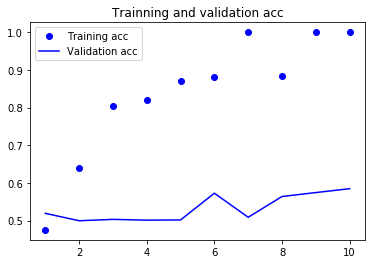

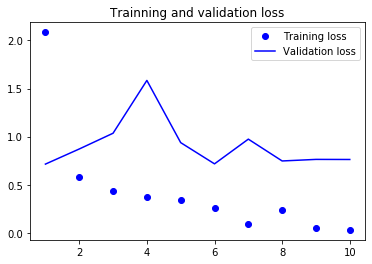

In [62]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Trainning and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Trainning and validation loss')
plt.legend()

plt.show()

사전 훈련된 단어 임베딩을 사용하지 않고 학습하기

In [63]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val,y_val))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


C:\Users\opp06\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6972 - acc: 0.5100 - val_loss: 0.6908 - val_acc: 0.5229
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4966 - acc: 0.9850 - val_loss: 0.6898 - val_acc: 0.5294
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2742 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.5344
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1154 - acc: 1.0000 - val_loss: 0.7027 - val_acc: 0.5327
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0527 - acc: 1.0000 - val_loss: 0.6994 - val_acc: 0.5374
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.7029 - val_acc: 0.5362
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.7065 - val_acc: 0.5366
Epoch 8/10
200/200 [========

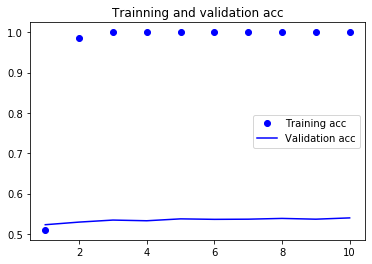

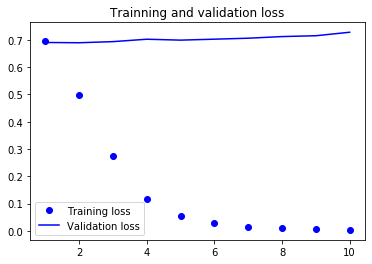

In [64]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Trainning and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Trainning and validation loss')
plt.legend()

plt.show()

테스트 데이터 모델 평가

In [66]:
import os

imdb_dir = './datasets/aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

#데이터에 긍정 부정 라벨링하기
labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname), encoding='utf-8')
        texts.append(f.read())
        f.close()
        if (label_type =='neg'):
            labels.append(0) #부정일 경우 0
        else:
            labels.append(1) #긍정일 경우 1
            
sequencees = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [67]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 2s 95us/step


[0.7630736256027222, 0.5833200216293335]